In [20]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from dataclasses import dataclass
import torch.nn as nn

import matplotlib.pyplot as plt

from tqdm import tqdm

### Polynomial Trend

In [21]:
class PolynomialProcess:
    """data generating process"""
    def __init__(self, type='linear', seq_len=2000, num_seeds=3, num_samples_per_task=100):
        self.type = type
        self.seq_len = seq_len
        self.num_seeds = num_seeds
        self.n = num_samples_per_task
        
    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, taskseq = [], [], []
        tseq = []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 1000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            taskseq.append(dat[2])
            tseq.append(dat[2])
            
        xseq = np.array(xseq)
        yseq = np.array(yseq)
        tseq = np.array(tseq)
        taskseq = np.array(taskseq)

        self.data = {'x': xseq,
                     'y': yseq,
                     't': tseq,
                     'task': taskseq}

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        data = []
        for s in range(self.seq_len):
            x, y, t = self.generate_at_time(s, self.n)
            data.append([x, y, t])
        data = np.concatenate(data, axis=-1)
        Xdat = data[0, :].reshape(-1, 1)
        Ydat = data[1, :].astype(int)
        tind = data[2, :]
        return Xdat, Ydat, tind
    
    def generate_at_time(self, t, num_samples, return_tensors=False):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor
        """
        m = 0.1
        if self.type == 'linear':
            trend = lambda t : m * t
        elif self.type == 'quadratic':
            trend = lambda t : m * t**2
        else:
            raise ValueError(f"Unknown process type: {self.type}")

        x1 = np.random.uniform(trend(t)-11, trend(t)-10, num_samples // 2)
        x2 = np.random.uniform(trend(t)+10, trend(t)+11, num_samples // 2)

        x = np.concatenate((x1, x2))
        y = np.concatenate((np.ones(num_samples // 2), np.zeros(num_samples // 2)))

        ts = t * np.ones(num_samples)

        if return_tensors:  
            x = torch.from_numpy(x.reshape(-1, 1)).float()
            y = torch.from_numpy(y.reshape(-1)).long()
            t = torch.from_numpy(ts.reshape(-1)).float()
            return x, y, t
        else:
            return x, y, ts
    
# class SyntheticDataset(Dataset):
#     """Form the torch dataset"""
#     def __init__(self, data, present, run_id, test, normalize=True):
#         x = torch.from_numpy(data['x'][run_id]).float()
#         y = torch.from_numpy(data['y'][run_id]).long()
#         t = torch.from_numpy(data['t'][run_id]).float()

#         train_idx = torch.where(t < present)
#         x_tr = x[train_idx]
#         y_tr = y[train_idx]
#         t_tr = t[train_idx]

#         test_idx = torch.where(t >= present)
#         x_te = x[test_idx]
#         y_te = y[test_idx]
#         t_te = t[test_idx]

#         self.x_tr = x_tr
#         self.y_tr = y_tr
#         self.t_tr = t_tr
        
#         if test:
#             self.x = self.minimax_normalize(x_te, x_tr)
#             self.t = self.minimax_normalize(t_te, t_tr)
#             self.y = y_te
#         else:
#             self.x = self.minimax_normalize(x_tr, x_tr)
#             self.t = self.minimax_normalize(t_tr, t_tr)
#             self.y = y_tr

#     def minimax_normalize(self, a, a_tr):
#         tr_min, tr_max = a_tr.min(), a_tr.max()
#         return (a - tr_min)/(tr_max - tr_min)

#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         x = self.x[idx]
#         y = self.y[idx]
#         t = self.t[idx]
#         return x, y, t

### ABAB Process

In [22]:
class ABABProcess:
    """data generating process"""
    def __init__(self, period=20, seq_len=10000, num_seeds=3, num_samples_per_task=20):
        self.seq_len = seq_len
        self.num_seeds = num_seeds
        self.period = period
        self.num_samples_per_task = num_samples_per_task

    def generate_data(self):
        """generate data sequences over the specified number of seeds"""
        xseq, yseq, tseq = [], [], []
        for _ in range(self.num_seeds):
            dat = self.generate_sequence(np.random.randint(0, 10000))
            xseq.append(dat[0])
            yseq.append(dat[1])
            tseq.append(dat[2])

        self.data = {
            'x': xseq,
            'y': yseq,
            't': tseq,
        }

    def generate_sequence(self, seed):
        """generate a sequence of data"""
        np.random.seed(seed)

        data = []
        for s in range(self.seq_len):
            x, y, t = self.generate_at_time(s, self.num_samples_per_task)
            data.append([x, y, t])
        data = np.concatenate(data, axis=-1)
        Xdat = data[0, :].reshape(-1, 1)
        Ydat = data[1, :].astype(int)
        tind = data[2, :]
        return Xdat, Ydat, tind

    
    def generate_at_time(self, t, num_samples, return_tensors=False):
        """generate a test sample of data (x, y) ~ p_t from the marginal 
        of the process at time t. This is used to evaluate the instantaneous
        loss of the predictor

        might not be needed
        """
        # Generate samples from U[-2, -1] union U[1, 2]
        x1 = np.random.uniform(-2, -1, num_samples)
        x2 = np.random.uniform(1, 2, num_samples)
        mask = np.random.choice([0, 1], p=[0.5, 0.5], size=num_samples)
        Xdat = x1 * mask + x2 * (1 - mask)

        # create labels
        T = self.period
        if (t % T) < (T // 2):
            Ydat = Xdat > 0
        else:
            Ydat = Xdat < 0

        tdat = t * np.ones(num_samples)

        if return_tensors:
            x = torch.from_numpy(Xdat.reshape(-1, 1)).float()
            y = torch.from_numpy(Ydat.reshape(-1)).long()
            t = torch.from_numpy(tdat.reshape(-1)).float()
            return x, y, t
        else:
            return Xdat, Ydat, tdat

In [23]:
class SyntheticDataset(Dataset):
    """Form the torch dataset"""
    def __init__(self, data, present, run_id, test, normalize_x=False, normalize_t=False):
        x = torch.from_numpy(data['x'][run_id]).float()
        y = torch.from_numpy(data['y'][run_id]).long()
        t = torch.from_numpy(data['t'][run_id]).float()

        train_idx = torch.where(t < present)
        x_tr = x[train_idx]
        y_tr = y[train_idx]
        t_tr = t[train_idx]

        test_idx = torch.where(t >= present)
        x_te = x[test_idx]
        y_te = y[test_idx]
        t_te = t[test_idx]

        self.x_tr = x_tr
        self.y_tr = y_tr
        self.t_tr = t_tr
        
        if test:
            self.x = self.minimax_normalize(x_te, x_tr) if normalize_x else x_te
            self.t = self.minimax_normalize(t_te, t_tr) if normalize_t else t_te
            self.y = y_te
        else:
            self.x = self.minimax_normalize(x_tr, x_tr) if normalize_x else x_tr
            self.t = self.minimax_normalize(t_tr, t_tr) if normalize_t else t_tr
            self.y = y_tr

    def minimax_normalize(self, a, a_tr):
        tr_min, tr_max = a_tr.min(), a_tr.max()
        return (a - tr_min)/(tr_max - tr_min)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        t = self.t[idx]
        return x, y, t

### Model

In [24]:
class FourierEmbedding(nn.Module):
    """form the Fourier time-embedding"""
    def __init__(self, tdim=50):
        super(FourierEmbedding, self).__init__()
        self.freqs = (2 * np.pi) / torch.arange(2, tdim + 1, 2).unsqueeze(0)

    def forward(self, t):
        t = t.unsqueeze(-1)
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)
    
class PolynomialEmbedding(nn.Module):
    """form the polynomial time-embedding"""
    def __init__(self, tdim=4):
        super(PolynomialEmbedding, self).__init__()
        self.tdim = tdim

    def forward(self, t):
        t = t.unsqueeze(-1)
        return torch.cat([torch.pow(t, k) for k in range(1, self.tdim+1)], dim=-1).to(t.device)

class MLP(nn.Module):
    """a simple MLP architecture for implementing both vanilla-MLP and
    prospective-MLP
    """
    def __init__(self, hidden_dim=[1, 32, 2], prospective=False, embedding_type='fourier', tdim=10):
        super(MLP, self).__init__()
        self.prospective = prospective
        
        if prospective:
            if embedding_type == 'fourier':
                self.embedding = FourierEmbedding(tdim)
            elif embedding_type == 'polynomial':
                self.embedding = PolynomialEmbedding(tdim)
            else:
                raise ValueError(f"Unknown embedding type: {embedding_type}")

        self.layers = nn.ModuleList()
        for i in range(len(hidden_dim)-1):
            if prospective and i == 0:
                self.layers.append(nn.Linear(hidden_dim[i] + tdim, hidden_dim[i+1]))
            else:
                self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        self.relu = nn.ReLU()

    def forward(self, x, t):
        if self.prospective:
            t = self.embedding(t)
            x = torch.cat([x, t], dim=-1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers)-1:
                x = self.relu(x)
        return x

In [25]:
import random

def set_seed(acorn):
    """set random seed"""
    random.seed(acorn)
    np.random.seed(acorn)
    torch.manual_seed(acorn)
    torch.cuda.manual_seed(acorn)
    torch.cuda.manual_seed_all(acorn)

def get_dataloaders(dp, t, seed, normalize_x, normalize_t):
    """obtain the dataloaders"""
    train_dataset = SyntheticDataset(dp.data, t, seed, test=False, normalize_x=normalize_x, normalize_t=normalize_t)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True, normalize_x=normalize_x, normalize_t=normalize_t)

    x, y, t = dp.generate_at_time(t, 500, return_tensors=True)
    x = train_dataset.minimax_normalize(x, train_dataset.x_tr) if normalize_x else x
    t = train_dataset.minimax_normalize(t, train_dataset.t_tr) if normalize_t else t
    ttest_dataset = TensorDataset(x, y, t)

    if len(train_dataset) > 32:
        bs = 32
    else:
        bs = 2

    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

class Trainer:
    """trainer class for the models"""
    def __init__(self, model, train_loader, test_loader, ttest_loader, criterion, optimizer, device, verbose=False):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.ttest_loader = ttest_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.verbose = verbose

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0.0
        
        for batch in self.train_loader:
            batch = [b.to(self.device) for b in batch]
            x, y, t = batch
            outputs = self.model(x, t)

            loss = self.criterion(outputs.squeeze(), y)

            self.optimizer.zero_grad()  
            loss.backward()            
            self.optimizer.step() 

            total_loss += loss.clone().detach().item()

        return total_loss / len(self.train_loader)

    def evaluate(self, model=None):
        if model is not None:
            self.model = model
        self.model.eval()
        perrs = []
        with torch.no_grad():
            for batch in self.test_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                perrs.append(err.detach().cpu().numpy())
        perrs = np.concatenate(perrs)
        times = self.test_loader.dataset.t.numpy()
        ploss = np.mean([np.mean(perrs[times == i]) for i in np.unique(times)])

        errs = []
        with torch.no_grad():
            for batch in self.ttest_loader:
                batch = [b.to(self.device) for b in batch]
                x, y, t = batch
                logits = self.model(x, t)
                probs = torch.softmax(logits, dim=1)
                err = (probs.argmax(dim=1) != y).float()
                errs.append(err.cpu().numpy())
        iloss = np.concatenate(errs).mean()
        
        return ploss, iloss

    def train(self, num_epochs):
        progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
        for epoch in progress_bar:
            train_loss = self.train_one_epoch()
            if self.verbose:
                progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f}")

In [36]:
# data generating args
process = 'ABAB' # or 'ABAB' or 'Linear'
seq_len = 500
num_seeds = 3
num_samples_per_task = 20
period = 20

# model args
hidden_dim = [1, 8, 8, 2]

# training args
num_epochs = 100
lr = 0.01
criterion = nn.CrossEntropyLoss()

# experiment args
t_list = np.arange(50, 450+1, 50) # list of time steps 

In [37]:
if process == 'Linear':
    dp = PolynomialProcess(
        type='linear',
        seq_len=seq_len,
        num_seeds=num_seeds,
        num_samples_per_task=num_samples_per_task
    )
    methods = [
        {"name": "FTL", "is_prospective" : False, "embedding_type" : "None", "tdim" : 0, "normalize_x" : True, "normalize_t" : False},
        {"name": "P-MLP (fourier)", "is_prospective" : True, "embedding_type" : "fourier", "tdim" : 50, "normalize_x" : True, "normalize_t" : False},
        {"name": "P-MLP (polynomial)", "is_prospective" : True, "embedding_type" : "polynomial", "tdim" : 4, "normalize_x" : True, "normalize_t" : True},
    ]
elif process == 'ABAB':
    dp = ABABProcess(
        period=period,
        seq_len=seq_len,
        num_seeds=num_seeds,
        num_samples_per_task=num_samples_per_task
    )
    methods = [
        {"name": "FTL", "is_prospective" : False, "embedding_type" : "None", "tdim" : 0, "normalize_x" : False, "normalize_t" : False},
        {"name": "P-MLP (fourier)", "is_prospective" : True, "embedding_type" : "fourier", "tdim" : 50, "normalize_x" : False, "normalize_t" : False},
        {"name": "P-MLP (polynomial)", "is_prospective" : True, "embedding_type" : "polynomial", "tdim" : 4, "normalize_x" : False, "normalize_t" : True},
    ]
else:
    raise ValueError(f"Unknown process type: {process}")


dp.generate_data()

In [38]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

instant_risk = {} # store instant risk for each algorithm
prospective_risk = {} # store prospective risk for each algorithm

for method in methods:
    print(f"Method: {method}")
    instant_losses = []
    prospective_losses = []
    for seed in range(num_seeds):
        print(f"seed = {seed}")
        acorn = seed * 1000 + 1996
        set_seed(acorn)

        iloss_list = []
        ploss_list = []
        
        for t in t_list:
            print(f"time t = {t}")

            trainloader, testloader, ttestloader = get_dataloaders(
                dp, t, seed, 
                normalize_x=method["normalize_x"],
                normalize_t=method["normalize_t"],
            )
        
            model = MLP(
                hidden_dim=hidden_dim,
                prospective=method["is_prospective"], 
                embedding_type=method["embedding_type"],
                tdim=method["tdim"]
            )
            model.to(device)

            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=lr,
                momentum=0.9, 
                nesterov=True,
                weight_decay=0.00001
            )

            trainer = Trainer(model, trainloader, testloader, ttestloader, criterion, optimizer, device, verbose=True)

            if t > 2:
                trainer.train(num_epochs=num_epochs)
                
            ploss, iloss = trainer.evaluate()
            iloss_list.append(iloss)
            ploss_list.append(ploss)
            print(f"instant loss: {iloss:.4f}, prospective loss: {ploss:.4f}")

        instant_losses.append(iloss_list)
        prospective_losses.append(ploss_list)

    instant_risk[method["name"]] = np.stack(instant_losses).mean(axis=0)
    prospective_risk[method["name"]] = np.stack(prospective_losses).mean(axis=0)

Method: {'name': 'FTL', 'is_prospective': False, 'embedding_type': 'None', 'tdim': 0, 'normalize_x': False, 'normalize_t': False}
seed = 0
time t = 50


Epoch [100/100] - Loss: 0.6740: 100%|██████████| 100/100 [00:01<00:00, 52.80epoch/s]


instant loss: 1.0000, prospective loss: 0.5111
time t = 100


Epoch [100/100] - Loss: 0.6932: 100%|██████████| 100/100 [00:03<00:00, 29.08epoch/s]


instant loss: 0.5220, prospective loss: 0.5045
time t = 150


Epoch [100/100] - Loss: 0.6908: 100%|██████████| 100/100 [00:04<00:00, 20.04epoch/s]


instant loss: 0.7200, prospective loss: 0.5081
time t = 200


Epoch [100/100] - Loss: 0.6935: 100%|██████████| 100/100 [00:06<00:00, 14.78epoch/s]


instant loss: 0.1700, prospective loss: 0.4985
time t = 250


Epoch [100/100] - Loss: 0.6929: 100%|██████████| 100/100 [00:08<00:00, 11.98epoch/s]


instant loss: 1.0000, prospective loss: 0.5200
time t = 300


Epoch [100/100] - Loss: 0.6934: 100%|██████████| 100/100 [00:10<00:00,  9.98epoch/s]


instant loss: 0.4960, prospective loss: 0.5058
time t = 350


Epoch [100/100] - Loss: 0.6931: 100%|██████████| 100/100 [00:11<00:00,  8.62epoch/s]


instant loss: 0.8800, prospective loss: 0.5267
time t = 400


Epoch [100/100] - Loss: 0.6934: 100%|██████████| 100/100 [00:13<00:00,  7.50epoch/s]


instant loss: 0.4820, prospective loss: 0.5025
time t = 450


Epoch [100/100] - Loss: 0.6929: 100%|██████████| 100/100 [00:14<00:00,  6.68epoch/s]


instant loss: 0.5020, prospective loss: 0.4990
seed = 1
time t = 50


Epoch [100/100] - Loss: 0.6742: 100%|██████████| 100/100 [00:01<00:00, 58.07epoch/s]


instant loss: 1.0000, prospective loss: 0.5111
time t = 100


Epoch [100/100] - Loss: 0.6932: 100%|██████████| 100/100 [00:03<00:00, 29.63epoch/s]


instant loss: 0.6440, prospective loss: 0.5111
time t = 150


Epoch [100/100] - Loss: 0.6912: 100%|██████████| 100/100 [00:05<00:00, 19.83epoch/s]


instant loss: 1.0000, prospective loss: 0.5143
time t = 200


Epoch [100/100] - Loss: 0.6937: 100%|██████████| 100/100 [00:06<00:00, 14.91epoch/s]


instant loss: 0.6020, prospective loss: 0.5112
time t = 250


Epoch [100/100] - Loss: 0.6930: 100%|██████████| 100/100 [00:08<00:00, 11.89epoch/s]


instant loss: 1.0000, prospective loss: 0.5200
time t = 300


Epoch [100/100] - Loss: 0.6930: 100%|██████████| 100/100 [00:09<00:00, 10.03epoch/s]


instant loss: 0.5200, prospective loss: 0.5125
time t = 350


Epoch [100/100] - Loss: 0.6932: 100%|██████████| 100/100 [00:11<00:00,  8.61epoch/s]


instant loss: 0.6900, prospective loss: 0.5203
time t = 400


Epoch [100/100] - Loss: 0.6935: 100%|██████████| 100/100 [00:13<00:00,  7.47epoch/s]


instant loss: 0.4720, prospective loss: 0.5020
time t = 450


Epoch [100/100] - Loss: 0.6930: 100%|██████████| 100/100 [00:14<00:00,  6.68epoch/s]


instant loss: 0.5060, prospective loss: 0.5010
seed = 2
time t = 50


Epoch [100/100] - Loss: 0.6744: 100%|██████████| 100/100 [00:01<00:00, 57.99epoch/s]


instant loss: 1.0000, prospective loss: 0.5111
time t = 100


Epoch [100/100] - Loss: 0.6934: 100%|██████████| 100/100 [00:03<00:00, 29.47epoch/s]


instant loss: 0.5700, prospective loss: 0.5024
time t = 150


Epoch [100/100] - Loss: 0.6919: 100%|██████████| 100/100 [00:05<00:00, 19.95epoch/s]


instant loss: 1.0000, prospective loss: 0.5143
time t = 200


Epoch [100/100] - Loss: 0.6936: 100%|██████████| 100/100 [00:06<00:00, 14.85epoch/s]


instant loss: 0.5240, prospective loss: 0.4987
time t = 250


Epoch [100/100] - Loss: 0.6933: 100%|██████████| 100/100 [00:08<00:00, 12.04epoch/s]


instant loss: 1.0000, prospective loss: 0.5200
time t = 300


Epoch [100/100] - Loss: 0.6935: 100%|██████████| 100/100 [00:09<00:00, 10.03epoch/s]


instant loss: 0.4820, prospective loss: 0.5068
time t = 350


Epoch [100/100] - Loss: 0.6930: 100%|██████████| 100/100 [00:11<00:00,  8.57epoch/s]


instant loss: 1.0000, prospective loss: 0.5333
time t = 400


Epoch [100/100] - Loss: 0.6936: 100%|██████████| 100/100 [00:13<00:00,  7.51epoch/s]


instant loss: 0.5200, prospective loss: 0.5225
time t = 450


Epoch [100/100] - Loss: 0.6933: 100%|██████████| 100/100 [00:15<00:00,  6.66epoch/s]


instant loss: 0.9100, prospective loss: 0.5730
Method: {'name': 'P-MLP (fourier)', 'is_prospective': True, 'embedding_type': 'fourier', 'tdim': 50, 'normalize_x': False, 'normalize_t': False}
seed = 0
time t = 50


Epoch [100/100] - Loss: 0.0002: 100%|██████████| 100/100 [00:01<00:00, 55.46epoch/s]


instant loss: 1.0000, prospective loss: 0.3280
time t = 100


Epoch [100/100] - Loss: 0.0001: 100%|██████████| 100/100 [00:03<00:00, 28.27epoch/s]


instant loss: 0.1440, prospective loss: 0.2190
time t = 150


Epoch [100/100] - Loss: 0.0001: 100%|██████████| 100/100 [00:05<00:00, 18.88epoch/s]


instant loss: 0.8220, prospective loss: 0.0707
time t = 200


Epoch [100/100] - Loss: 0.0001: 100%|██████████| 100/100 [00:07<00:00, 14.26epoch/s]


instant loss: 0.1360, prospective loss: 0.0070
time t = 250


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.32epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 300


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:10<00:00,  9.50epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 350


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:12<00:00,  8.16epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 400


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:14<00:00,  7.12epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 450


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:15<00:00,  6.38epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
seed = 1
time t = 50


Epoch [100/100] - Loss: 0.0002: 100%|██████████| 100/100 [00:01<00:00, 55.61epoch/s]


instant loss: 1.0000, prospective loss: 0.3506
time t = 100


Epoch [100/100] - Loss: 0.0010: 100%|██████████| 100/100 [00:03<00:00, 27.99epoch/s]


instant loss: 0.1640, prospective loss: 0.2142
time t = 150


Epoch [100/100] - Loss: 0.0002: 100%|██████████| 100/100 [00:05<00:00, 19.01epoch/s]


instant loss: 0.7040, prospective loss: 0.0961
time t = 200


Epoch [100/100] - Loss: 0.0001: 100%|██████████| 100/100 [00:07<00:00, 14.09epoch/s]


instant loss: 0.0500, prospective loss: 0.0102
time t = 250


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.46epoch/s]


instant loss: 0.0000, prospective loss: 0.0008
time t = 300


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:10<00:00,  9.53epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 350


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:12<00:00,  8.14epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 400


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:13<00:00,  7.15epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 450


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:15<00:00,  6.36epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
seed = 2
time t = 50


Epoch [100/100] - Loss: 0.0005: 100%|██████████| 100/100 [00:01<00:00, 55.92epoch/s]


instant loss: 1.0000, prospective loss: 0.3602
time t = 100


Epoch [100/100] - Loss: 0.0001: 100%|██████████| 100/100 [00:03<00:00, 28.56epoch/s]


instant loss: 0.5160, prospective loss: 0.2370
time t = 150


Epoch [100/100] - Loss: 0.0002: 100%|██████████| 100/100 [00:05<00:00, 18.99epoch/s]


instant loss: 0.8460, prospective loss: 0.0889
time t = 200


Epoch [100/100] - Loss: 0.0001: 100%|██████████| 100/100 [00:06<00:00, 14.32epoch/s]


instant loss: 0.1840, prospective loss: 0.0240
time t = 250


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:08<00:00, 11.45epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 300


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:10<00:00,  9.65epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 350


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:12<00:00,  8.25epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 400


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:13<00:00,  7.22epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
time t = 450


Epoch [100/100] - Loss: 0.0000: 100%|██████████| 100/100 [00:15<00:00,  6.40epoch/s]


instant loss: 0.0000, prospective loss: 0.0000
Method: {'name': 'P-MLP (polynomial)', 'is_prospective': True, 'embedding_type': 'polynomial', 'tdim': 4, 'normalize_x': False, 'normalize_t': True}
seed = 0
time t = 50


Epoch [100/100] - Loss: 0.3560: 100%|██████████| 100/100 [00:01<00:00, 55.51epoch/s]


instant loss: 1.0000, prospective loss: 0.5091
time t = 100


Epoch [100/100] - Loss: 0.6543: 100%|██████████| 100/100 [00:03<00:00, 28.93epoch/s]


instant loss: 1.0000, prospective loss: 0.5081
time t = 150


Epoch [100/100] - Loss: 0.6489: 100%|██████████| 100/100 [00:05<00:00, 19.42epoch/s]


instant loss: 1.0000, prospective loss: 0.5101
time t = 200


Epoch [100/100] - Loss: 0.6768: 100%|██████████| 100/100 [00:06<00:00, 14.48epoch/s]


instant loss: 1.0000, prospective loss: 0.5117
time t = 250


Epoch [100/100] - Loss: 0.6815: 100%|██████████| 100/100 [00:08<00:00, 11.71epoch/s]


instant loss: 1.0000, prospective loss: 0.5046
time t = 300


Epoch [100/100] - Loss: 0.6896: 100%|██████████| 100/100 [00:10<00:00,  9.74epoch/s]


instant loss: 1.0000, prospective loss: 0.5140
time t = 350


Epoch [100/100] - Loss: 0.6914: 100%|██████████| 100/100 [00:11<00:00,  8.38epoch/s]


instant loss: 1.0000, prospective loss: 0.5113
time t = 400


Epoch [100/100] - Loss: 0.6913: 100%|██████████| 100/100 [00:13<00:00,  7.31epoch/s]


instant loss: 1.0000, prospective loss: 0.5140
time t = 450


Epoch [100/100] - Loss: 0.6909: 100%|██████████| 100/100 [00:15<00:00,  6.49epoch/s]


instant loss: 1.0000, prospective loss: 0.5970
seed = 1
time t = 50


Epoch [100/100] - Loss: 0.2906: 100%|██████████| 100/100 [00:01<00:00, 56.85epoch/s]


instant loss: 1.0000, prospective loss: 0.4976
time t = 100


Epoch [100/100] - Loss: 0.6455: 100%|██████████| 100/100 [00:03<00:00, 28.79epoch/s]


instant loss: 0.9780, prospective loss: 0.5141
time t = 150


Epoch [100/100] - Loss: 0.6824: 100%|██████████| 100/100 [00:05<00:00, 19.20epoch/s]


instant loss: 1.0000, prospective loss: 0.4954
time t = 200


Epoch [100/100] - Loss: 0.6800: 100%|██████████| 100/100 [00:06<00:00, 14.58epoch/s]


instant loss: 1.0000, prospective loss: 0.4990
time t = 250


Epoch [100/100] - Loss: 0.6819: 100%|██████████| 100/100 [00:08<00:00, 11.64epoch/s]


instant loss: 1.0000, prospective loss: 0.5166
time t = 300


Epoch [100/100] - Loss: 0.6899: 100%|██████████| 100/100 [00:10<00:00,  9.78epoch/s]


instant loss: 1.0000, prospective loss: 0.5142
time t = 350


Epoch [100/100] - Loss: 0.6900: 100%|██████████| 100/100 [00:11<00:00,  8.41epoch/s]


instant loss: 1.0000, prospective loss: 0.5137
time t = 400


Epoch [100/100] - Loss: 0.6921: 100%|██████████| 100/100 [00:13<00:00,  7.29epoch/s]


instant loss: 0.4720, prospective loss: 0.5020
time t = 450


Epoch [100/100] - Loss: 0.6920: 100%|██████████| 100/100 [00:15<00:00,  6.49epoch/s]


instant loss: 1.0000, prospective loss: 0.5980
seed = 2
time t = 50


Epoch [100/100] - Loss: 0.2986: 100%|██████████| 100/100 [00:01<00:00, 55.53epoch/s]


instant loss: 1.0000, prospective loss: 0.5088
time t = 100


Epoch [100/100] - Loss: 0.6435: 100%|██████████| 100/100 [00:03<00:00, 29.00epoch/s]


instant loss: 1.0000, prospective loss: 0.5014
time t = 150


Epoch [100/100] - Loss: 0.6553: 100%|██████████| 100/100 [00:05<00:00, 19.53epoch/s]


instant loss: 1.0000, prospective loss: 0.5090
time t = 200


Epoch [100/100] - Loss: 0.6875: 100%|██████████| 100/100 [00:06<00:00, 14.46epoch/s]


instant loss: 1.0000, prospective loss: 0.5042
time t = 250


Epoch [100/100] - Loss: 0.6878: 100%|██████████| 100/100 [00:08<00:00, 11.67epoch/s]


instant loss: 1.0000, prospective loss: 0.5144
time t = 300


Epoch [100/100] - Loss: 0.6871: 100%|██████████| 100/100 [00:10<00:00,  9.72epoch/s]


instant loss: 1.0000, prospective loss: 0.5145
time t = 350


Epoch [100/100] - Loss: 0.6865: 100%|██████████| 100/100 [00:11<00:00,  8.33epoch/s]


instant loss: 1.0000, prospective loss: 0.5263
time t = 400


Epoch [100/100] - Loss: 0.6924: 100%|██████████| 100/100 [00:13<00:00,  7.24epoch/s]


instant loss: 1.0000, prospective loss: 0.5000
time t = 450


Epoch [100/100] - Loss: 0.6926: 100%|██████████| 100/100 [00:15<00:00,  6.42epoch/s]

instant loss: 1.0000, prospective loss: 0.6000


In [39]:
# save the results
import pickle
with open(f"embedding_results_{process}.pkl", "wb") as f:
    pickle.dump({
        "instant_risk": instant_risk,
        "prospective_risk": prospective_risk,
        "t_list": t_list
    }, f)

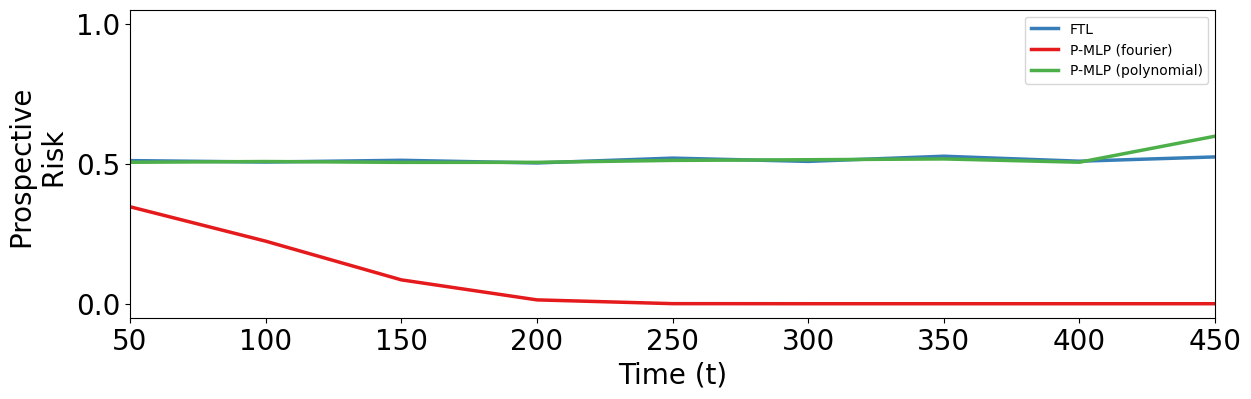

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4), sharex=True)
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00']

fontsize = 20
lw = 2.5

for i, method in enumerate(methods):
    ax.plot(t_list, prospective_risk[method["name"]], color=colors[i], lw=lw, label=method["name"])
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

ax.grid(visible=False)

ax.set_ylabel("Prospective \n Risk", fontsize=fontsize)
ax.set_xlabel("Time (t)", fontsize=fontsize)

ax.tick_params(axis='both', labelsize=fontsize)

ax.legend()

plt.show()

### Make Figures

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("default")
sns.set(
    context='poster',
    style='ticks',
    font_scale=0.9,
    rc={'axes.grid':True,
        'grid.color':'.9',
        'grid.linewidth':0.75}
)
plt.rcParams.update({'font.size': 16})
from matplotlib.lines import Line2D

import numpy as np
import pickle

In [3]:
def load_results(file):
    with open(file, 'rb') as file:
        results = pickle.load(file)
    return results

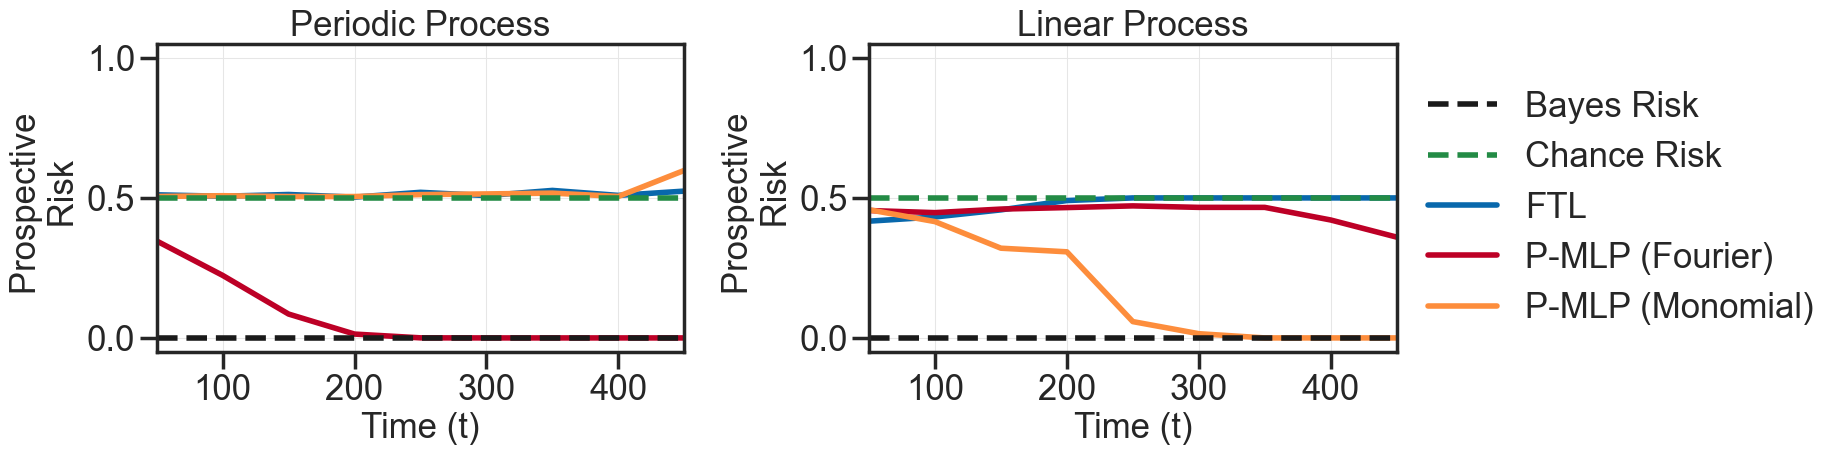

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
colors = ['#0868ac', '#bd0026', '#fd8d3c']

fontsize = 25
lw = 4

methods = ["FTL", "P-MLP (fourier)", "P-MLP (polynomial)"]

ax = axes[0]
results = load_results(f"embedding_results_ABAB.pkl")
t_list = results["t_list"]
prospective_risk = results["prospective_risk"]
for i, method in enumerate(methods):
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=lw, label=method)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])
ax.set_title("Periodic Process", fontsize=fontsize)

ax = axes[1]
results = load_results(f"embedding_results_Linear.pkl")
t_list = results["t_list"]
prospective_risk = results["prospective_risk"]
for i, method in enumerate(methods):
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=lw, label=method)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])
ax.set_title("Linear Process", fontsize=fontsize)

for ax in axes:
    ax.plot(t_list, np.zeros_like(t_list), lw=lw, ls='dashed', color='k', label="Bayes Risk")
    ax.plot(t_list, 0.5*np.ones_like(t_list), lw=lw, ls='dashed', color='#238b45', label="Chance Risk")
    ax.set_xlabel("Time (t)", fontsize=fontsize)
    ax.set_ylabel("Prospective \n Risk", fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.grid(visible=True)

plt.subplots_adjust(wspace=0.35)

legend_elements = [
    Line2D([0], [0], color='k', lw=4, ls='dashed', label='Bayes Risk'),
    Line2D([0], [0], color='#238b45', lw=4, ls='dashed', label='Chance Risk'),
    Line2D([0], [0], color='#0868ac', lw=4, label='FTL'),
    Line2D([0], [0], color='#bd0026', lw=4, label='P-MLP (Fourier)'),
    Line2D([0], [0], color='#fd8d3c', lw=4, label='P-MLP (Monomial)'),
]

ax = axes[1]
ax.legend(
    handles=legend_elements, 
    frameon=False, 
    loc='upper left', 
    bbox_to_anchor=(1, 0.95),
    fontsize=fontsize   
)

plt.savefig(f"figures/3_effect_of_time_embed.pdf", bbox_inches='tight')
plt.show()

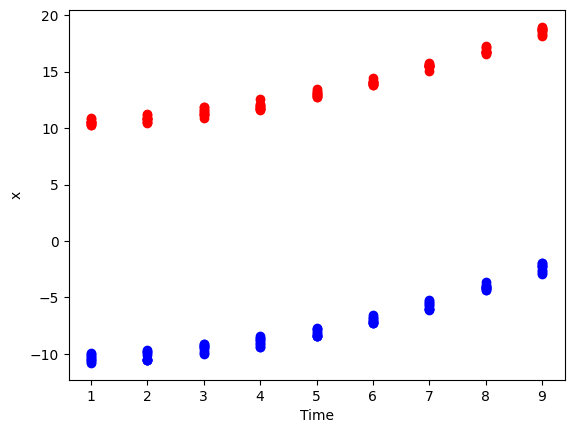

In [44]:
x, y, t = dp.generate_sequence(1996)

for i in range(1, 10):
    indices = (t == i)
    xi = x[indices]
    ti = t[indices]
    yi = y[indices]
    plt.scatter(ti[yi == 0], xi[yi == 0], color='red')
    plt.scatter(ti[yi == 1], xi[yi == 1], color='blue')
plt.xlabel("Time")
plt.ylabel("x")
plt.show()